In [17]:
from __future__ import division
import numpy as np
from numpy.random import choice, dirichlet, binomial, multinomial, beta, gamma, normal,exponential#, gaussian
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
import seaborn as sns

import pdb
%matplotlib inline



In [2]:
import csv
def read_data(file_path):
    # The read-in data should be a N*W matrix,
    # where N is the length of the time sequences,
    # W is the number of sensors/data features
    i = 0
    with open(file_path, 'r') as file:
        reader = csv.reader(file, delimiter = ',')
        for line in reader:
            line = np.array(line, dtype = 'float') # str2float
            if i == 0:
                data = line
            else:
                data = np.vstack((data, line))
            i += 1
    return data

In [13]:
# generate stick-breaking
def GEM(gma):
    beta_product = 1
    while True:
        beta_k = beta(1,gma)
        pi_k = beta_k * beta_product
        beta_product *= (1-beta_k)
        yield pi_k
        

[ 0.00285224  0.01928198  0.0176008   0.00021613  0.00133183  0.00354572
  0.00546871  0.01156271  0.00395281  0.02242231  0.0047793   0.01269407
  0.02446767  0.00517254  0.01030405  0.01215745  0.00063854  0.0189667
  0.02298218  0.02081548]
('pi:', array([  9.64916212e-02,   8.62437610e-02,   3.32403191e-02,
         5.73027391e-06,   1.35403204e-03,   1.23511389e-02,
         4.22707556e-02,   3.26046050e-02,   1.72155325e-02,
         5.54509438e-02,   8.20589878e-03,   1.12661558e-01,
         1.15888595e-01,   2.42027937e-02,   4.42269408e-02,
         4.37802282e-02,   4.37971426e-11,   9.55801924e-02,
         1.40093821e-01,   3.81315326e-02]))


<function matplotlib.pyplot.show>

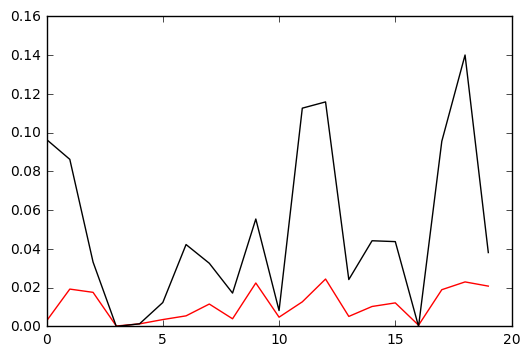

In [3]:
d_max = 20 # maximum number of state

gma = 100 # parameter for GEM distribution
stick_breaking = GEM(gma)
beta_gem = np.array([next(stick_breaking) for i in range(d_max)])
print (beta_gem)
plt.plot(range(d_max), beta_gem,'r')
plt.show

alpha = 100 # concentration parameter for DP
pi = dirichlet(alpha*beta_gem)
print ("pi:", pi)
plt.plot(range(d_max), pi,'k')
plt.show
# G0 = beta_gem*gamma()


In [50]:
result = binomial(0,0.5)
print (result)


0


array([ 5.,  5.,  5.,  5.,  5.])

In [57]:
class DirichletProcess():
    def __init__(self, data,max_k=20,gma=1,alpha=1,kappa=1,nu=2,sigma_a=2,sigma_b=2,kmeans_init=True):
        self.data = data
        
        self.n = data.shape[0] # number of data instances
        self.d = data.shape[1] # number of data dimensions
        
        self.alpha = alpha
        self.kappa = kappa
        self.nu = nu
        self.a = sigma_a
        self.b = sigma_b
        
        # max number of clusters
        self.max_k = max_k
        # randomly initialize states of the data
        if kmeans_init:
            self.state = np.reshape(kmeans2(self.data.ravel(), self.max_k)[1], self.data.shape)
        else:
            self.state = choice(self.max_k,self.data.shape)
        # compute parameter for each cluster
        std = np.std(self.data)
        self.mu = normal(0, std, self.max_k)
        self.sigma = np.ones(self.max_k)*std
        for k in range(self.max_k):
            idx = np.where(self.state==k)
            if idx[0].size:
                cluster = self.data[idx]
                self.mu[k] = np.mean(cluster)
                self.sigma[k] = np.std(cluster)
            else:
                cluster = []
                self.mu[k] = normal(0, np.sqrt(self.nu))
                self.sigma[k] = 1 / gamma(self.a, self.b)
        
        # stick-breaking construction
        self.gma = gma # parameter for GEM distribution
        self.stick_breaking = self.GEM()
        self.beta = np.array([next(self.stick_breaking) for i in range(self.max_k)]) # the weights of samples.
        
        # initialize the transition matrix
        self.N = np.zeros((self.max_k, self.max_k))
        for i in range(1, self.n):
            for j in range(self.d):
                self.N[self.state[i-1,j], self.state[i,j]] += 1
        self.pi = (self.N.T/(np.sum(self.N, axis=1)+1e-7)).T
        
        # hierarchical construction
#         self.G0 = np.zeros(self.max_k)
#         self.Gj = np.zeros((self.max_k, self.max_k))
        
        
        
        self.log_likelihood_list = []
    def log_likelihood(self,x,mu,sigma):
        return (-1/2) * ((x-mu)/sigma)**2 - np.log(np.sqrt(2*np.pi)*sigma)#
    
    def GEM(self):
        beta_product = 1
        while True:
            beta_k = beta(1,self.gma)
            pi_k = beta_k * beta_product
            beta_product *= (1-beta_k)
            yield pi_k
        
    def run(self):
        pdb.set_trace()
        # Step 1, forward-backward algorithm
        forward,backward = self.message_passing()
        
        # Step 2, Metropolis-Hasting algorithm for state update
        self.MH_sampling(forward, backward)
        
        # step 3, run HDP
        self.HDP()
        
        # check log likelihood
        emis = 0
        trans = 0
        for t in range(self.n):
            emis += self.log_likelihood(self.data[t,:], self.mu[self.state[t,:]], self.sigma[self.state[t,:]])
            if t > 0:
                trans += np.log(self.pi[self.state[t-1,:],self.state[t,:]])
        self.log_likelihood_list.append(emis+trans)
#         print ("emis:",emis)
#         print ("trans:",trans)
        return emis+trans
    
    def message_passing(self):
        # forward
        alpha = np.zeros((self.n, self.max_k))
        alpha[0, :] = 1
        for t in range(1, self.n):
            alpha[t,:] = (self.pi.dot(alpha[t-1,:])) * np.exp(self.log_likelihood(self.data[t,:], self.mu, self.sigma))
            
        # backward
        beta = np.zeros((self.n, self.max_k))
        beta[-1, :] = 1
        for t in range(self.n - 1, 0, -1):
            beta[t-1, :] = self.pi.dot(beta[t, :] * np.exp(self.log_likelihood(self.data[t,:], self.mu, self.sigma)))
#             beta[t-1, :] /= np.max(beta[t-1, :])
                        
        return alpha, beta
        
    def MH_sampling(self, alpha, beta):
        for t in range(1,self.n):
            # propose a candidate
            j = choice(self.max_k)
            k = self.state[t,:]
            # alpha[t-1,j] *
            # alpha[t-1,k] *
#             num =  alpha[t-1,j] *beta[t,j] * self.pi[self.state[t-1,:],j] * np.exp(self.log_likelihood(self.data[t,:], self.mu[j], self.sigma[j]))
#             den =  alpha[t-1,k] *beta[t,k] * self.pi[self.state[t-1,:],k] * np.exp(self.log_likelihood(self.data[t,:], self.mu[k], self.sigma[k]))
                                       
#             acceptance = 1 if num/den >1 or den == 0 else num/den
#             u = np.random.rand(1)
#             if u < acceptance:
#                 self.state[t,:] = j
#                 self.N[self.state[t-1, :], j] += 1
#                 self.N[self.state[t-1, :], k] -= 1
                
            logprob_accept = (np.log(alpha[t-1,k]) -
                              np.log(alpha[t-1,j]) +
                              np.log(beta[t, k]) -
                              np.log(beta[t, j]) +
                              np.log(self.pi[self.state[t-1, :], k]) -
                              np.log(self.pi[self.state[t-1, :], j]) +
                              self.log_likelihood(self.data[t-1, :], 
                                                  self.mu[k], 
                                                  self.sigma[k]) -
                              self.log_likelihood(self.data[t-1, :], 
                                                  self.mu[j], 
                                                  self.sigma[j]))
            if exponential(1) > logprob_accept: 
                self.state[t, :] = j
                self.N[self.state[t-1, :], j] += 1
                self.N[self.state[t-1, :], k] -= 1
                        
    def HDP(self):
#         stick_breaking = GEM(self.gma)
#         self.G0 = np.array([next(stick_breaking) for i in range(self.max_k)]) # the weights of samples.
        
        # draw beta from G0, place a dirichlet prior on beta with symmetric parameters
        self.beta = dirichlet(np.ones(self.max_k)* (self.gma/self.max_k))
        
        # draw pi from Gj, place a dirichlet prior on pi with beta as base measure.
        tmp = np.tile(self.alpha * self.beta,(self.max_k,1)) + self.N
        np.fill_diagonal(tmp, np.diag(tmp) + self.kappa)
        for j in range(self.max_k):
            self.pi[j,:] = dirichlet(tmp[j,:])
            idx = np.where(self.state == j)
            cluster = self.data[idx]
            nc = cluster.size
            if nc:
                tmp_mu = np.mean(cluster)
                tmp_sigma = np.var(cluster)
                self.mu[j] = tmp_mu / (self.nu / nc + 1)
                self.sigma[j] = (2 * self.b + (nc - 1) * tmp_sigma + 
                                 nc * tmp_mu ** 2 / (self.nu + nc)) / (2 * self.a + nc - 1)
            else:
                self.mu[j] = normal(0, np.sqrt(self.nu))
                self.sigma[j] = 1 / gamma(self.a, self.b)
                
    def get_path(self):
        path = np.zeros(self.data.shape)
        for k,mu in enumerate(self.mu):
            path[np.where(self.state==k)] = mu
        return path

<function matplotlib.pyplot.show>

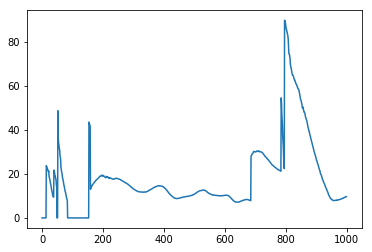

In [30]:
data_path = "obs_data_16d.csv"
data = read_data(data_path)
data = data[15500:16500,0:1]
data.shape
plt.plot(range(data.shape[0]),data)
plt.show

In [62]:
DP = DirichletProcess(data, kappa = 10)

/home/brianyao/home/brianyao/Envs/tf/lib/python3.5/site-packages/scipy/cluster/vq.py:660: UserWarning: One of the clusters is empty. Re-run kmean with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [63]:
DP.sigma

array([ 0.59072121,  0.07214439,  0.96799789,  0.30855248,  0.53688471,
        3.45015982,  0.51993119,  0.80490693,  0.6264982 ,  4.59679084,
        0.4875835 ,  0.        ,  0.51450222,  0.63974978,  0.56892868,
        0.42865388,  0.54406693,  0.36996585,  5.80975999,  2.13260033])

In [64]:
i = 0
while i < 500:
    print ("num iter:", i)
    log_likelihood = DP.run()
    i += 1
    print ("log-likelihood:", log_likelihood)
path = DP.get_path()
plt.figure(1)
sns.heatmap(DP.state[:, 0:1].T, cbar=False)
plt.figure(2)
plt.plot(range(DP.n),path,'r')
plt.show
all_states, state_counts = np.unique(DP.state, return_counts=True)
print("all states: ", all_states)
print("state counts: ", state_counts)

num iter: 0
log-likelihood: [-2311.43033493]
num iter: 1
log-likelihood: [-2305.06405531]
num iter: 2


/home/brianyao/home/brianyao/Envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/home/brianyao/home/brianyao/Envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log
/home/brianyao/home/brianyao/Envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/home/brianyao/home/brianyao/Envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in subtract
/home/brianyao/home/brianyao/Envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:129: RuntimeWarning: divide by zero encountered in log
/home/brianyao/home/brianyao/Envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in subtract
/home/brianyao/home/brianyao/Envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encount

log-likelihood: [-2303.25842967]
num iter: 3
log-likelihood: [-2308.53199039]
num iter: 4
log-likelihood: [-2321.3661617]
num iter: 5
log-likelihood: [-2314.0666812]
num iter: 6
log-likelihood: [-2324.35820847]
num iter: 7
log-likelihood: [-2315.08048462]
num iter: 8
log-likelihood: [-2317.19339384]
num iter: 9
log-likelihood: [-2314.73114914]
num iter: 10
log-likelihood: [-2308.60895738]
num iter: 11
log-likelihood: [-2306.10380231]
num iter: 12
log-likelihood: [-2315.26641101]
num iter: 13
log-likelihood: [-2307.7741207]
num iter: 14
log-likelihood: [-2323.45342289]
num iter: 15
log-likelihood: [-2313.24335815]
num iter: 16
log-likelihood: [-2301.68647614]
num iter: 17
log-likelihood: [-2309.18891858]
num iter: 18
log-likelihood: [-2315.31353627]
num iter: 19
log-likelihood: [-2307.45076149]
num iter: 20
log-likelihood: [-2305.59970619]
num iter: 21
log-likelihood: [-2314.78469078]
num iter: 22
log-likelihood: [-2311.24851113]
num iter: 23
log-likelihood: [-2317.87503723]
num iter: 2

KeyboardInterrupt: 

In [16]:
plt.figure(1)
G0 = dirichlet(np.ones(DP.max_k) * (alpha/DP.max_k))
print (sum(G0))
for j in range(DP.max_k):
    plt.plot([j,j],[0,G0[j]])
plt.show

plt.figure(2)
stick_breaking = GEM(alpha)
G0_new = np.array([next(stick_breaking) for i in range(DP.max_k)]) # the weights of samples.
print (sum(G0_new))
for j in range(DP.max_k):
    plt.plot([j,j],[0,G0_new[j]])
plt.show


NameError: name 'alpha' is not defined

In [39]:
DP.alpha

1

0